In [1]:
from pandas import read_excel, DataFrame, merge, cut
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats
import seaborn as sb
import numpy as np
from patsy import dmatrix
import sys
import os
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency
import statsmodels.api as sm

from helper import myOls

ImportError: cannot import name 'myOls' from 'helper' (c:\Users\jehyu\Desktop\nationalSupport\SemiProject3\helper.py)

In [2]:
df=read_excel("세미프로젝트3.xlsx")
df

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [3]:
#원본 데이터 유지하기 위해 카피본 생성
df1=df.copy()

for문으로 컬럼 돌려서 수치가 0인값, 0이 아닌값 찾아보기

In [4]:
for column in df1.columns:
    zero_count = df1.loc[df1[column] == 0].shape[0]
    number_count = df1.loc[df1[column] != 0].shape[0]
    print('0 개수 :',{column : zero_count})
    print('0 아닌 수 :',{column : number_count})
    print('-'*30)

0 개수 : {'총생활비': 0}
0 아닌 수 : {'총생활비': 7865}
------------------------------
0 개수 : {'이자_배당금_연간소득': 5489}
0 아닌 수 : {'이자_배당금_연간소득': 2376}
------------------------------
0 개수 : {'임대료_연간소득': 6707}
0 아닌 수 : {'임대료_연간소득': 1158}
------------------------------
0 개수 : {'기타_소득': 1439}
0 아닌 수 : {'기타_소득': 6426}
------------------------------
0 개수 : {'세금환급금': 6275}
0 아닌 수 : {'세금환급금': 1590}
------------------------------
0 개수 : {'금융기관대출': 5500}
0 아닌 수 : {'금융기관대출': 2365}
------------------------------
0 개수 : {'주거관련_부채의_이자': 6414}
0 아닌 수 : {'주거관련_부채의_이자': 1451}
------------------------------
0 개수 : {'주택관련_부채액': 5342}
0 아닌 수 : {'주택관련_부채액': 2523}
------------------------------
0 개수 : {'공적연금_연간소득': 4777}
0 아닌 수 : {'공적연금_연간소득': 3088}
------------------------------


# `이상치/결측치` 확인 및 처리

- 종속변수
>총생활비

- 독립변수
> '이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금','금융기관대출'</br>
> '주거관련_부채의_이자','주택관련_부채액','공적연금_연간소득'

- 불로소득에 포함되는 변수
>이자_배당금_연간소득, 임대료_연간소득, 공적연금_연간소득,세금환급금

사용할 분석방법 후보

1. 피어슨 상관분석

2. 회귀분석(단순회귀,다중회귀)

3. 

In [5]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

In [6]:
df1.head()

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0


결측치 확인

In [7]:
#해당 데이터에서 한번에 결측치 조회하는 방법
df1.isna().sum()

총생활비              0
이자_배당금_연간소득       0
임대료_연간소득          0
기타_소득             0
세금환급금             0
금융기관대출            0
주거관련_부채의_이자       0
주택관련_부채액       1079
공적연금_연간소득         0
dtype: int64

주택관련_부채액 결측치 1079건 수치값'0'으로 간주하고 대체

In [8]:
re_df1=df1.fillna(value=0)
re_df1

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


In [9]:
re_df1.isna().sum()

총생활비           0
이자_배당금_연간소득    0
임대료_연간소득       0
기타_소득          0
세금환급금          0
금융기관대출         0
주거관련_부채의_이자    0
주택관련_부채액       0
공적연금_연간소득      0
dtype: int64

## #전처리1. 종속/독립변수 상관관계 파악

동시에 이상치 확인

귀무가설: 총생활비와 y값의 상관이 없다.<br>
대립가설: 총생활비는 y값과 상관이 있다.

### 각 컬럼 별 이상치 찾기(1)

#### 보기 쉽게 sub plot 및 for문 이용해서 한번에 조회 (regplot)

In [10]:
# 그래프 생성을 위해 컬럼 이름, 길이 확인
re_df1.head()
re_df1.columns
len(re_df1.columns)

9

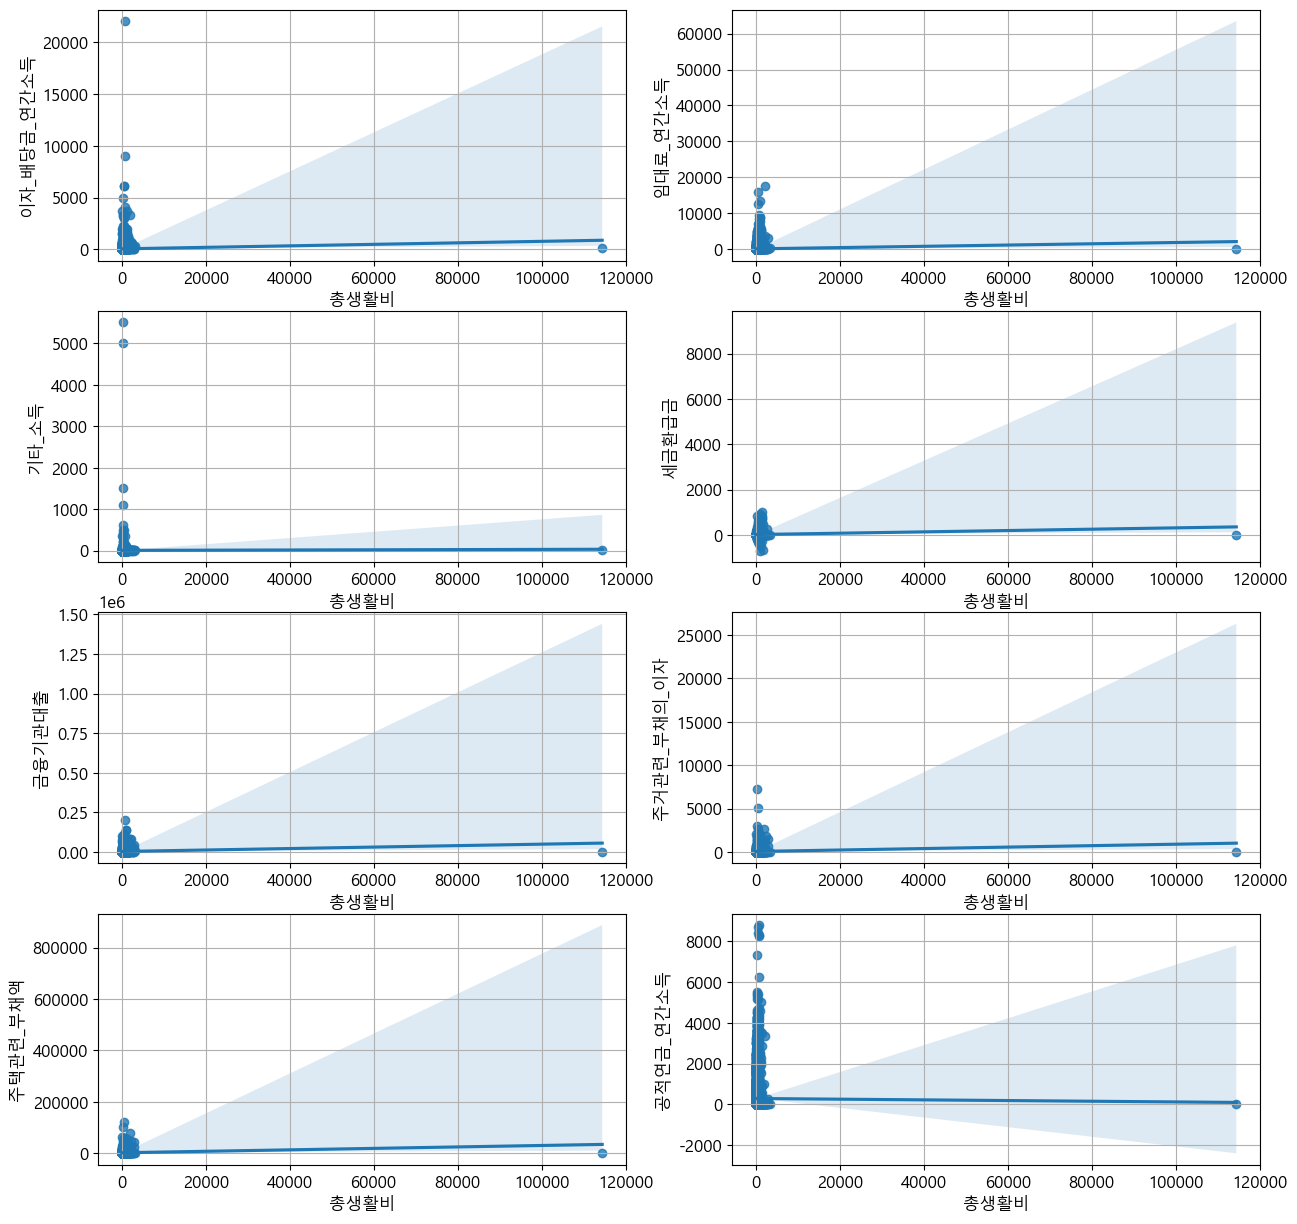

In [11]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(re_df1.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=re_df1, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid()

plt.show()
plt.close()

### 각 컬럼 별 이상치 찾기(2)

#### 보기 쉽게 sub plot 및 for문 이용해서 한번에 조회 (boxplot)

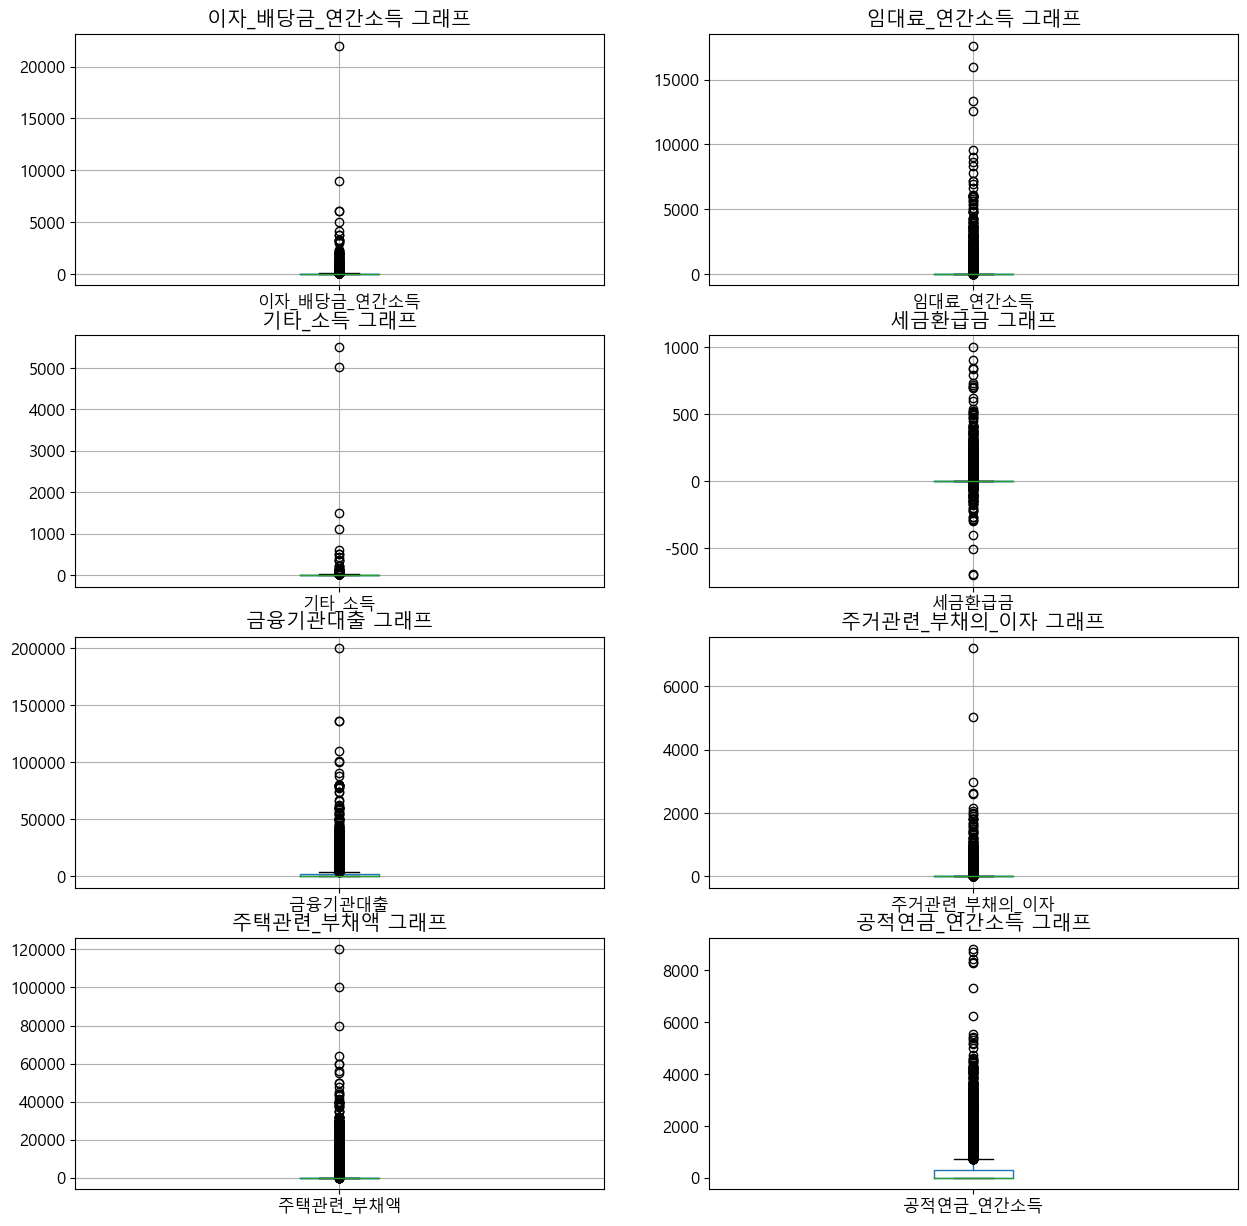

In [12]:
# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    re_df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.show()

### regplot, boxplot 조회 결과

1) x값으로 넣을 종속변수(총생활비)에서 1건만 비정상으로 높은 수치 확인되어 제거하고 진행

2) y값으로 넣을 독립변수들 중 이상치가 각 컬럼에서 발견되어 프로젝트 참가자들 주관적 판단에 의해 제거하기로 결정

3) 이자_배당금_연간소득 상위이상치 2건, 임대료_연간소득 상위이상치 4건,기타_소득 상위이상치 4건,<br>
     주택관련_부채액 상위이상치 3건, 공적연금_연간소득 상위이상치 7건<br>
     세금환급금 상위이상치 8건, 금융기관대출 상위이상치 2건, 주거관련_부채의_이자 상위이상치 4건

4) 종속변수,독립변수 포함해서 총35건의 데이터 제거하였음

이상치 행 제외하고 재조회

In [13]:
df2=re_df1.query('(총생활비 < 5000) and (이자_배당금_연간소득 < 7000) and (임대료_연간소득 < 11000) and\
                 (기타_소득 < 1000) and (주택관련_부채액 <75000) and (공적연금_연간소득 <6000) and \
                 (세금환급금 > -500 and 세금환급금 < 750)\
                 and (금융기관대출 < 125000) and (주거관련_부채의_이자 < 2500)')
df2

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
0,275,0.0,0,7.0,0.0,10000,0,0.0,0
1,239,0.0,0,7.0,0.0,0,0,0.0,0
2,156,0.0,80,7.0,0.0,14000,720,20500.0,540
3,541,140.0,0,9.0,0.0,0,0,0.0,0
4,85,50.0,0,7.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...
7860,384,0.0,0,1.0,70.0,3000,96,3000.0,0
7861,715,0.0,660,1.0,90.0,40000,0,0.0,0
7862,595,0.0,4000,1.0,0.0,25947,67,25947.0,0
7863,562,40.0,0,0.0,0.0,12000,360,12000.0,0


이상치 데이터 제거후 추세선이 올라오는지 regplot으로 그래프 재확인하기

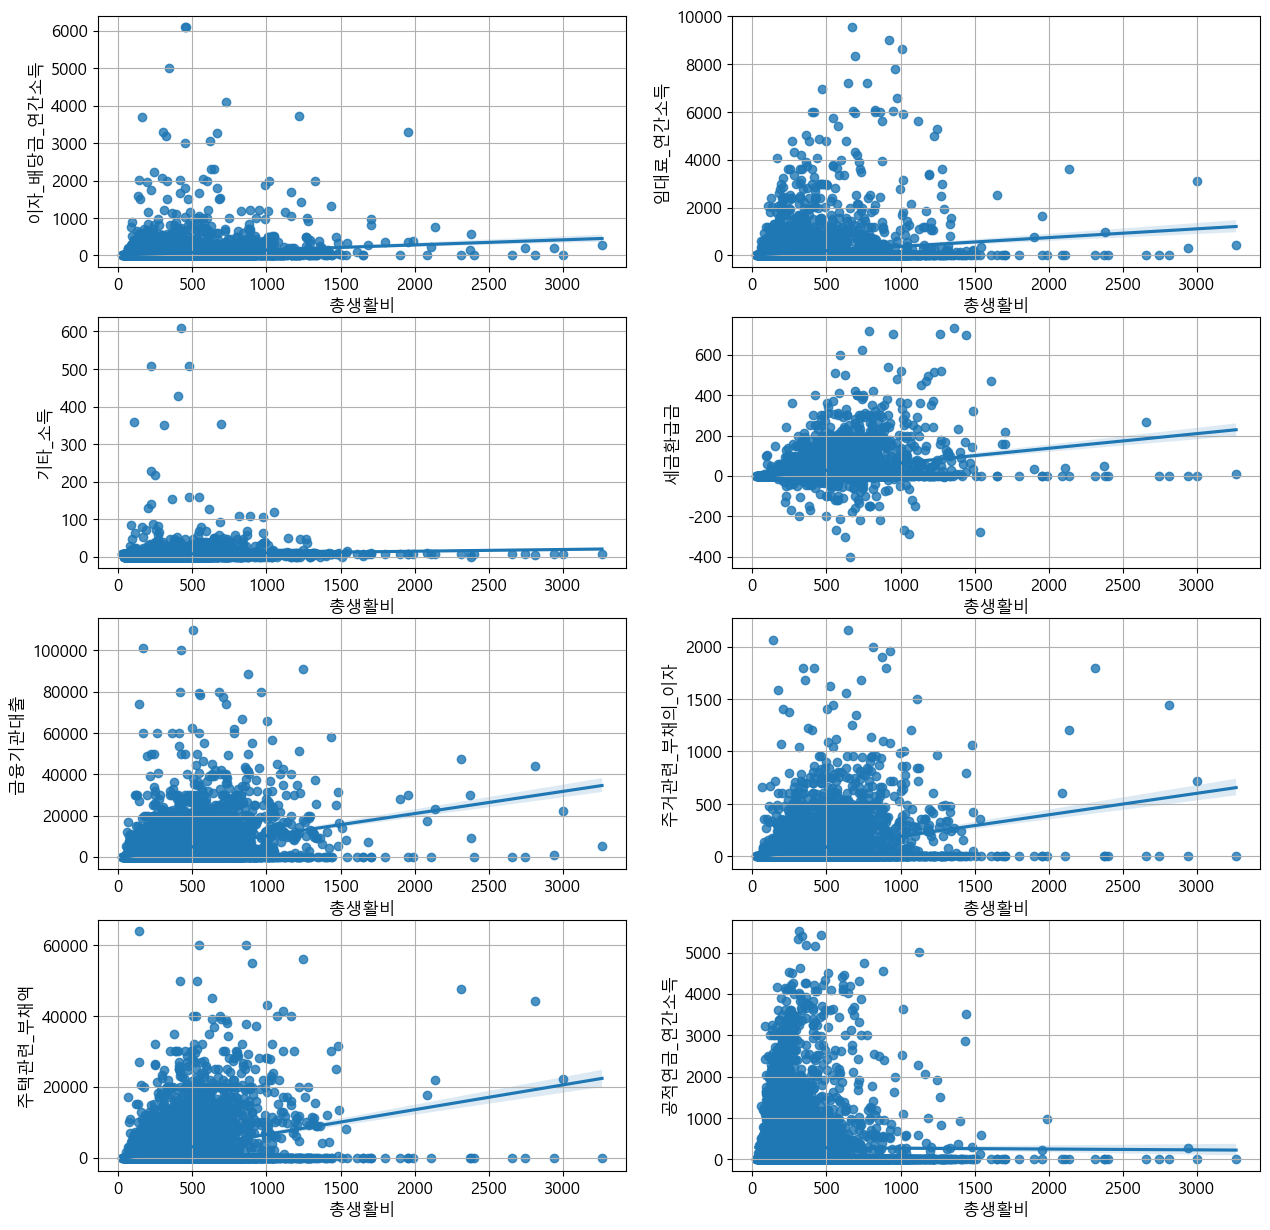

In [14]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리려고 시도함
columns = list(df2.columns)[1:]

# 4행 2열로 8개의 서브플롯 그래프 그리기
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# 종속변수 설정
dependent_variable = '총생활비'

for i, c in enumerate(columns):
    row, col = divmod(i, 2)
    sb.regplot(data=df2, x=dependent_variable, y=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    ax[row, col].grid()

plt.show()
plt.close()

피어슨 상관분석 통해 상관계수와 p-value값 확인하기

In [15]:
correlations = {}
columns = df2.select_dtypes(include=[float, int]).columns

for col in columns:
    if col != '총생활비':
        r, p = stats.pearsonr(df2['총생활비'], df2[col])
        correlations[col] = (r, p)

# 결과 출력
for col, (r, p) in correlations.items():
    print(f"'총생활비' and '{col}' 간의 상관분석:")
    print(f"상관계수: {r}")
    print(f"P-value: {p}")
    print("-" * 30)

'총생활비' and '이자_배당금_연간소득' 간의 상관분석:
상관계수: 0.1631473829793282
P-value: 7.638725754080436e-48
------------------------------
'총생활비' and '임대료_연간소득' 간의 상관분석:
상관계수: 0.17811669108795497
P-value: 7.956642651475088e-57
------------------------------
'총생활비' and '기타_소득' 간의 상관분석:
상관계수: 0.07896518600206891
P-value: 2.610774564146715e-12
------------------------------
'총생활비' and '세금환급금' 간의 상관분석:
상관계수: 0.35837229167487744
P-value: 5.522347059288661e-236
------------------------------
'총생활비' and '금융기관대출' 간의 상관분석:
상관계수: 0.38025485911675916
P-value: 7.898255190935233e-268
------------------------------
'총생활비' and '주거관련_부채의_이자' 간의 상관분석:
상관계수: 0.34095817570967957
P-value: 2.2417650986055645e-212
------------------------------
'총생활비' and '주택관련_부채액' 간의 상관분석:
상관계수: 0.3627198847176846
P-value: 4.089108192874763e-242
------------------------------
'총생활비' and '공적연금_연간소득' 간의 상관분석:
상관계수: -0.008377261997174455
P-value: 0.45858682790782124
------------------------------


그래프와 피어슨 상관분석을 바탕으로 총생활비(=소비금액) 금액이 커질수록 불로소득(이자_배당금_연간소득, 임대료_연간소득, 세금환급금)이 `양의 상관관계`를 가진다고 예측할 수 있다.

다만, `공적연금_연간소득`과는 상관관계가 크지 않다고 판단이 된다.

데이터프레임 객체를 통해 상관계수 구하기 및 히트맵 그래프로 시각화

In [16]:
corr = df2.corr(method='pearson')
corr

,총생활비,이자_배당금_연간소득,임대료_연간소득,기타_소득,세금환급금,금융기관대출,주거관련_부채의_이자,주택관련_부채액,공적연금_연간소득
총생활비,1.000000,0.163147,0.178117,0.078965,0.358372,0.380255,0.340958,0.362720,-0.008377
이자_배당금_연간소득,0.163147,1.000000,0.107434,0.019644,0.057853,0.050670,0.015769,0.024315,0.073351
임대료_연간소득,0.178117,0.107434,1.000000,0.017712,0.015072,0.188534,0.081602,0.070473,0.094136
기타_소득,0.078965,0.019644,0.017712,1.000000,0.049301,0.029858,0.016758,0.027468,0.001033
세금환급금,0.358372,0.057853,0.015072,0.049301,1.000000,0.199542,0.194347,0.226202,-0.085098
금융기관대출,0.380255,0.050670,0.188534,0.029858,0.199542,1.000000,0.667216,0.726963,-0.058325
주거관련_부채의_이자,0.340958,0.015769,0.081602,0.016758,0.194347,0.667216,1.000000,0.847931,-0.061578
주택관련_부채액,0.362720,0.024315,0.070473,0.027468,0.226202,0.726963,0.847931,1.000000,-0.075824
공적연금_연간소득,-0.008377,0.073351,0.094136,0.001033,-0.085098,-0.058325,-0.061578,-0.075824,1.000000


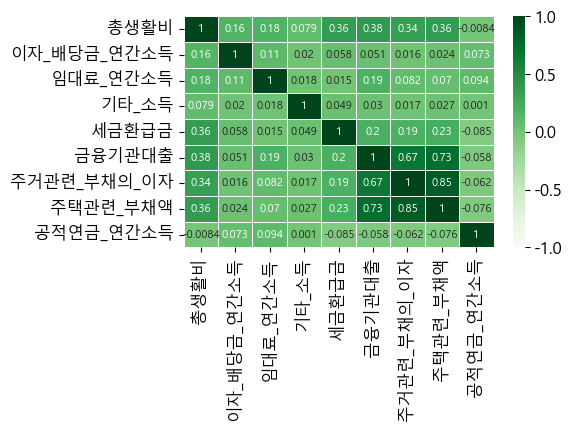

In [17]:
plt.rcParams["figure.figsize"] = (5,3)

sb.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상(Greys,Purples,Blues,Greens,Oranges,Reds,OrRd,PuRd,RdPu,BuPu,GnBu,PuBu,YlGnBu,PuBuGn,BuGn,YlGn)
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
           linewidths=.5, #구분선 굵기
           annot_kws={"size": 8}  # 글자 크기 조정
)

plt.show()
plt.close()

## #전처리2. 정규성/등분산성/독립성 확인

비모수적인 방법 사용, 로버스트(robust) 통계 기법 사용, 대규모 데이터셋 사용, 통계 기법과 목적에 따른 유연성(회귀분석의 예측 모델링이 목적)에 따라 정규성/등분산성/독립성 확인을 제외

현재 대규모 데이터셋을 사용하기 때문에 정규성, 등분산성, 독립성 확인은 제외하기로 결정

## #전처리3. 표준화-정규화(Scaling)

표준화(정규화)를 통해 서로 다른 단위나 범위를 가진 데이터를 동일한 기준으로 맞춤으로써, 데이터 분석이나 머신러닝 모델의 성능을 향상.

다만, 현재 사용중인 데이터에는 명목형(범주형)변수를 제외한 경우인 만큼 더미변수화 시킬 필요가 없다고 판단, 스케일링만 진행하기로 결정.

시간이 된다면 (표준화 적용한 결과/표준화를 적용하지 않은 결과의 차이를 비교, 학습)

데이터 정규화하기

In [18]:
scaler=StandardScaler()

df3=df2.copy()

df3.loc[:, '총생활비(std)'] = scaler.fit_transform(df3[['총생활비']])
df3.loc[:, '이자_배당금_연간소득(std)'] = scaler.fit_transform(df3[['이자_배당금_연간소득']])
df3.loc[:, '임대료_연간소득(std)'] = scaler.fit_transform(df3[['임대료_연간소득']])
df3.loc[:, '기타_소득(std)'] = scaler.fit_transform(df3[['기타_소득']])
df3.loc[:, '세금환급금(std)'] = scaler.fit_transform(df3[['세금환급금']])
df3.loc[:, '금융기관대출(std)'] = scaler.fit_transform(df3[['금융기관대출']])
df3.loc[:, '주거관련_부채의_이자(std)'] = scaler.fit_transform(df3[['주거관련_부채의_이자']])
df3.loc[:, '주택관련_부채액(std)'] = scaler.fit_transform(df3[['주택관련_부채액']])
df3.loc[:, '공적연금_연간소득(std)'] = scaler.fit_transform(df3[['공적연금_연간소득']])
df3.drop(['총생활비','이자_배당금_연간소득','임대료_연간소득','기타_소득','세금환급금','금융기관대출','주거관련_부채의_이자',
          '주택관련_부채액','공적연금_연간소득'],axis=1,inplace=True)

df3

,총생활비(std),이자_배당금_연간소득(std),임대료_연간소득(std),기타_소득(std),세금환급금(std),금융기관대출(std),주거관련_부채의_이자(std),주택관련_부채액(std),공적연금_연간소득(std)
0,-0.143361,-0.230332,-0.220614,0.015010,-0.260949,0.947127,-0.315830,-0.335186,-0.444685
1,-0.278210,-0.230332,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
2,-0.589112,-0.230332,-0.075289,0.015010,-0.260949,1.477286,4.170679,3.646416,0.406910
3,0.853023,0.399681,-0.220614,0.142735,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
4,-0.855064,-0.005327,-0.220614,0.015010,-0.260949,-0.378272,-0.315830,-0.335186,-0.444685
...,...,...,...,...,...,...,...,...,...
7860,0.264932,-0.230332,-0.220614,-0.368166,1.032604,0.019347,0.282372,0.247487,-0.444685
7861,1.504793,-0.230332,0.978317,-0.368166,1.402191,4.923324,-0.315830,-0.335186,-0.444685
7862,1.055296,-0.230332,7.045634,-0.368166,-0.260949,3.060741,0.101665,4.704356,-0.444685
7863,0.931685,-0.050328,-0.220614,-0.432028,-0.260949,1.212207,1.927425,1.995508,-0.444685


다중 선형 회귀 분석을 통해 데이터 검정 및 분석